# Part 3: Text Mining(Clustering) the News Stories

## Task 5 Text Mining

### 1. Loading Text Data

In [1]:
import pandas as pd

# load the dataset
df = pd.read_csv('C:/Users/Soam wei jie/Dropbox/Master sem 3/Data mining/Assessment 2/bbc.csv')

# random state
rs = 42


# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
TEXT            200 non-null object
URI             200 non-null object
NAME            200 non-null object
FILTERED        200 non-null object
LANGUAGE        200 non-null object
CREATED         200 non-null int64
ACCESSED        200 non-null int64
MODIFIED        200 non-null int64
TRUNCATED       200 non-null int64
OMITTED         200 non-null int64
EXTENSION       200 non-null object
SIZE            200 non-null int64
FILTEREDSIZE    200 non-null int64
dtypes: int64(7), object(6)
memory usage: 20.4+ KB


In [2]:
# print out the first 200 characters of the first row of text column
print(df.get_value(index=0, col='TEXT')[:200])

Claxton hunting first major medal  British hurdler Sarah Claxton is confident she can win her first major medal at next month's European Indoor Championships in Madrid.  The 25-year-old has already sm


C:\Users\Soam wei jie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [3]:
# average length of text column
print(df['TEXT'].apply(lambda x: len(x)).mean())

1927.73


### 2. Data Preprocessing

In [4]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [5]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

stopwords = set(sw.words('english'))


def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [6]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []

    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)

    return tokens

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1, 2))
X = tfidf_vec.fit_transform(df['TEXT'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

36360


### 3. Initial Document Analysis

Obtain the "optimal" K value using the elbow method and silhouette score

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

############# Elbow ################
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 10, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(range(2, 10, 1), inertia_vals, marker='*')
plt.show()

In [9]:
from sklearn.metrics import silhouette_score
#
# print(clusters[1])
# print("Silhouette score for k=4", silhouette_score(X, clusters[1].predict(X)))

print(clusters[2])
print("Silhouette score for k=4", silhouette_score(X, clusters[2].predict(X)))
print("_______________________________________________________________")

print(clusters[3])
print("Silhouette score for k=5", silhouette_score(X, clusters[3].predict(X)))
print("_______________________________________________________________")

print(clusters[4])
print("Silhouette score for k=6", silhouette_score(X, clusters[4].predict(X)))
print("_______________________________________________________________")

print(clusters[5])
print("Silhouette score for k=7", silhouette_score(X, clusters[5].predict(X)))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.008292309272847803
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.010785041854539794
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.011225470684704177
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=10, precompute_

From results of applying elbow method and silhouette score, we could  try `6` as the optimal `K` value

In [10]:
# K means clustering using the term vector
kmeans = KMeans(n_clusters=6, random_state=rs).fit(X)

In [11]:
# function to visualise text cluster. Useful for the assignment too
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word=5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.

    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]

    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()


# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: race, world, marathon, cross country, chepkemei, 
Top terms for cluster 1: open, australian, australian open, 6, grand slam, 
Top terms for cluster 2: drug, test, athletics, athens, ban, 
Top terms for cluster 3: say, game, play, win, cup, 
Top terms for cluster 4: england, ball, wale, williams, ireland, 
Top terms for cluster 5: club, want, liverpool, souness, player, 


###  4. Feature Selection and Transformation
#### 4.1. Zipf's Law and Document Frequency Filtering

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt


# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1, 2))
    X_count = count_vec.fit_transform(df['TEXT'])

    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]

    return terms


terms = calculate_tf_idf_terms(df['TEXT'])


## Terms sort by frequency

In [105]:
# sort terms by its frequency
terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)

# select a few of the terms for plotting purpose
sel_terms = [terms[i] for i in range(0, len(terms))]
labels = [term['term'] for term in sel_terms]
#print(labels)

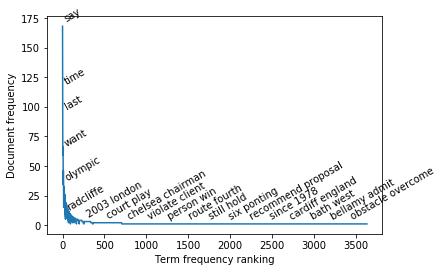

In [13]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step=10):
    from scipy.spatial.distance import euclidean
    from math import sqrt

    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step

    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)

    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]

    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')

    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])

    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels, range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 1.7
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2.2
        scaled_dist = sqrt(x_dist + y_dist)

        if (scaled_dist > 0.1):
            plt.text(x + 2, y + 2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y

    plt.show()

visualise_zipf(terms)

In [113]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 5 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=5, max_df=0.8)
X_filter = filter_vec.fit_transform(df['TEXT'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

1552


## Count the frequency of high frequent term after setting a parameter of document frequency less than 5, or over 80% have been removed

In [115]:
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1, 2), min_df=5, max_df=0.8)
    X_count = count_vec.fit_transform(df['TEXT'])

    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]

    return terms


terms = calculate_tf_idf_terms(df['TEXT'])

In [129]:
# sort terms by its frequency
terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)

# select a few of the terms for plotting purpose
sel_terms = [terms[i] for i in range(0, len(terms))]
labels = [term['term'] for term in sel_terms]
print(sel_terms[0])
print(sel_terms[1])
print(sel_terms[2])
print(sel_terms[3])
print(sel_terms[4])
print(sel_terms[5])
print(sel_terms[6])
print(sel_terms[7])
print(sel_terms[8])
print(sel_terms[9])
print(sel_terms[10])
print(sel_terms[11])
print(sel_terms[12])
print(sel_terms[13])
print(sel_terms[14])

{'term': 'year', 'idx': 1538, 'tf': 308, 'df': 134}
{'term': 'game', 'idx': 585, 'tf': 249, 'df': 106}
{'term': 'win', 'idx': 1501, 'tf': 246, 'df': 102}
{'term': 'play', 'idx': 1041, 'tf': 240, 'df': 104}
{'term': 'one', 'idx': 987, 'tf': 204, 'df': 104}
{'term': 'go', 'idx': 607, 'tf': 203, 'df': 112}
{'term': 'take', 'idx': 1359, 'tf': 202, 'df': 112}
{'term': 'england', 'idx': 451, 'tf': 199, 'df': 52}
{'term': 'two', 'idx': 1442, 'tf': 197, 'df': 103}
{'term': 'time', 'idx': 1407, 'tf': 189, 'df': 115}
{'term': 'first', 'idx': 533, 'tf': 185, 'df': 89}
{'term': 'world', 'idx': 1523, 'tf': 180, 'df': 92}
{'term': 'get', 'idx': 596, 'tf': 175, 'df': 87}
{'term': 'player', 'idx': 1045, 'tf': 164, 'df': 82}
{'term': 'make', 'idx': 866, 'tf': 163, 'df': 108}


## Selecting the number of K

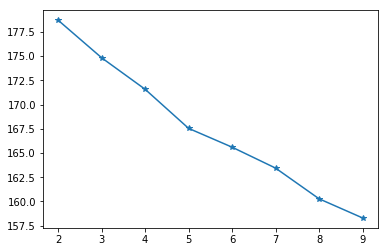

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

############# Elbow ################
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 10, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X_filter)
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(range(2, 10, 1), inertia_vals, marker='*')
plt.show()

In [68]:
from sklearn.metrics import silhouette_score
#
print(clusters[2])
print("Silhouette score for k=4", silhouette_score(X_filter, clusters[2].predict(X_filter)))
print("_______________________________________________________________")

print(clusters[3])
print("Silhouette score for k=5", silhouette_score(X_filter, clusters[3].predict(X_filter)))
print("_______________________________________________________________")

print(clusters[4])
print("Silhouette score for k=6", silhouette_score(X_filter, clusters[4].predict(X_filter)))
print("_______________________________________________________________")

print(clusters[5])
print("Silhouette score for k=7", silhouette_score(X_filter, clusters[5].predict(X_filter)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.029424736055407633
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=5 0.038010763426726844
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.03760645076166927
_______________________________________________________________
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=10, precompute_d

## SVD


In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

In [42]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 england, year, play, win, game, 
Top terms in component #1 6, open, 7, roddick, australian, 
Top terms in component #2 athletics, athens, world, race, olympic, 
Top terms in component #3 test, wicket, run, ball, pakistan, 
Top terms in component #4 ireland, wale, nation, scotland, six nation, 
Top terms in component #5 open, australian, australian open, clijsters, cricket, 
Top terms in component #6 greek, drug, kenteris, iaaf, thanou, 
Top terms in component #7 roddick, moya, cup, spain, davis, 
Top terms in component #8 chepkemei, cross country, marathon, radcliffe, country, 
Top terms in component #9 liverpool, 6, club, benitez, 7, 


In [65]:
svd_kmeans = KMeans(n_clusters=7, random_state=rs).fit(X_trans)

In [66]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: race, world, year, indoor, olympic, 
Top terms for cluster 1: 6, 7, roddick, moya, 3, 
Top terms for cluster 2: pakistan, ball, wicket, test, day, 
Top terms for cluster 3: open, australian, australian open, federer, grand slam, 
Top terms for cluster 4: england, wale, ireland, nation, six nation, 
Top terms for cluster 5: club, game, player, chelsea, play, 
Top terms for cluster 6: drug, ban, greek, test, iaaf, 
